In [1]:
import json
import pandas as pd
import numpy as np

In [1]:
import os
cwd = os.getcwd()

In [2]:
business_path_ori = cwd + "\\data\\yelp_academic_dataset_business.json"

In [3]:
covid_path = cwd + "\\data\\yelp_academic_dataset_covid_features.json"
business_path = cwd + "\\data\\yelp_academic_dataset_business.json"
user_path = cwd + "\\data\\yelp_academic_dataset_user.json"
review_path = cwd + "\\data\\yelp_academic_dataset_review.json"

## COVID data

In [42]:
covid_data = []
with open(covid_path, "r", encoding="utf-8") as f:
    Lines = f.readlines()
    for l in Lines:
        covid_data.append(json.loads(l))
covid = pd.DataFrame.from_dict(covid_data)

In [43]:
def highlight_json(s):
    if type(s) == str:
        highlight = json.loads(s)
        identifier_list = ""
        for item in highlight:
            identifier_list += item['identifier'] + ", "
        identifier_list = identifier_list.rsplit(', ', 1)[0]
        return identifier_list
    else:
        return s

str_to_int = {'FALSE':0, 'TRUE':1}

column_names = covid.columns
for col in column_names:
    if col != "business_id": 
        if col in ["highlights", "Covid Banner", "Temporary Closed Until", "Virtual Services Offered"]:
            covid.loc[covid[col] == "FALSE", col] = np.nan
            if col == "highlights":
                covid.highlights = covid.highlights.apply(highlight_json)
        else:
            covid[col] = covid[col].map(str_to_int)        

In [111]:
covid.to_csv("covid.csv", index = False)

## Business Data

In [5]:
business_data = []
with open(business_path_ori, "r", encoding="utf-8") as f:
    Lines = f.readlines()
    for l in Lines:
        business_data.append(json.loads(l))
business = pd.DataFrame.from_dict(business_data)

In [21]:
business['is_rest'] = 0

In [4]:
with open(cwd + "\\yelp_restaurant_cat.txt", "r") as f:
    lines = f.readlines()
rest_cat = [s.replace("\n","") for s in lines]

def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

for i in range(business.shape[0]):
    cat = business.categories.iloc[i]
    if type(cat) == str:
        cat_list = cat.split(", ")
        if len(intersection(rest_cat, cat_list)) > 0:
            business.is_rest.iloc[i] = 1

NameError: name 'business' is not defined

In [30]:
restaurant = business[business.is_rest == 1]

def attributes_json(s):
    if s == None:
        return np.nan
    if "RestaurantsPriceRange2" not in s.keys():
        return np.nan
    else:
        return s['RestaurantsPriceRange2']

restaurant["Price_Range"] = restaurant.attributes.apply(attributes_json)
restaurant = restaurant.drop(columns = ["address", "attributes", "hours"])

<ipython-input-30-eac201975f27>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant["Price_Range"] = restaurant.attributes.apply(attributes_json)


<AxesSubplot:xlabel='state'>

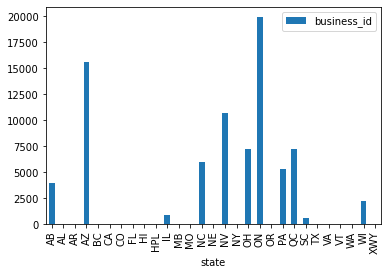

In [62]:
restaurant.groupby("state").agg({'business_id':'count'}).plot(kind='bar')

In [34]:
restaurant.to_csv("restaurant.csv", index = False)

In [48]:
restaurant_covid = restaurant.merge(covid, on="business_id", how="left")

def flatten(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

# Converting highlights into separate columns
restaurant_covid.highlights = restaurant_covid.highlights.replace(np.nan, "NA")
highlights_cat = restaurant_covid.highlights.unique()
l = []
for i in highlights_cat:
    if i is not np.nan:
        l.append(i.split(", "))
l_flat = flatten(l)
l_flat_unique = []
for i in set(l_flat):
    if "during_covid_19" in i:
        l_flat_unique.append(i)
for col in l_flat_unique:
    restaurant_covid[col] = 0
for i, h in enumerate(restaurant_covid.highlights):
    for col in l_flat_unique:
        restaurant_covid[col].iloc[i] = 1 if col in h else 0 

In [54]:
restaurant_covid.head()

,business_id,name,city,state,postal_code,latitude,longitude,stars,review_count,is_open,...,gift_cards_during_covid_19,drive_thru_during_covid_19,delivery_during_covid_19,online_classes_during_covid_19,curbside_pickup_during_covid_19,shipping_during_covid_19,takeout_during_covid_19,curbside_drop_off_during_covid_19,remote_services_during_covid_19,mobile_services_during_covid_19
0,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,Champaign,IL,61820,40.110446,-88.233073,4.5,5,1,...,0,0,0,0,0,0,0,0,0,0
1,M_guz7Dj7hX0evS672wIwA,Chocolate Shoppe Ice Cream,Middleton,WI,53562,43.105310,-89.510142,3.5,6,1,...,0,0,0,0,0,0,0,0,0,0
2,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,Charlotte,NC,28205,35.194894,-80.767442,3.0,5,0,...,0,0,0,0,0,0,0,0,0,0
3,mKTq1T_IAplDpHUcMzOXkw,Tipsy Ryde,Gastonia,NC,28054,35.252842,-81.152698,3.5,3,1,...,0,0,0,0,0,0,0,0,0,0
4,eBEfgOPG7pvFhb2wcG9I7w,Philthy Phillys,Aurora,ON,L4G 7J1,44.010962,-79.448677,4.5,4,1,...,0,0,0,0,0,0,0,0,0,0


In [52]:
restaurant_covid.shape

(79455, 32)

In [51]:
restaurant_covid.columns

Index(['business_id', 'name', 'city', 'state', 'postal_code', 'latitude',
       'longitude', 'stars', 'review_count', 'is_open', 'categories',
       'is_rest', 'Price_Range', 'highlights', 'delivery or takeout',
       'Grubhub enabled', 'Call To Action enabled', 'Request a Quote Enabled',
       'Covid Banner', 'Temporary Closed Until', 'Virtual Services Offered',
       'virtual_estimates_during_covid_19', 'gift_cards_during_covid_19',
       'drive_thru_during_covid_19', 'delivery_during_covid_19',
       'online_classes_during_covid_19', 'curbside_pickup_during_covid_19',
       'shipping_during_covid_19', 'takeout_during_covid_19',
       'curbside_drop_off_during_covid_19', 'remote_services_during_covid_19',
       'mobile_services_during_covid_19'],
      dtype='object')

In [53]:
restaurant_covid.to_csv("restaurant_covid.csv", index = False)